In [ ]:
import os
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from lifelines import KaplanMeierFitter
import json
import cv2

In [3]:
!pip install opencv-python

     |████████████████████████████████| 95.4 MB 112 kB/s eta 0:00:01     |███████████████▋                | 46.5 MB 1.2 MB/s eta 0:00:40
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Installing backend dependencies ... done
    Preparing wheel metadata ... done
  Created wheel for opencv-python: filename=opencv_python-4.12.0.88-cp36-cp36m-linux_x86_64.whl size=30771556 sha256=af7dd63d57d00626de7127dc6d97810456314a1ba83423fb936025826fdf44c4
  Stored in directory: /home/pbmf/.cache/pip/wheels/54/32/21/5626a8d2c531ec508e01dd796ad84dcb1cf6a8a76ad6dfbf28
Successfully built opencv-python
You should consider upgrading via the '/usr/bin/python3 -m pip install --upgrade pip' command.


In [7]:
# --- 1. 基础配置 ---
SAVE_PATH = "/mnt/ONCOBOX/geneplus/workspace/chenly/dataset"
TOTAL_SINGLE = 150
# final_df加载
final_df = pd.read_csv("cbioprotal_download_km/merged_km_data_cleaned.csv")
FILES = final_df['original_file'].unique()

# 提前创建目录
for split in ["train", "val"]:
    os.makedirs(f"{SAVE_PATH}/images/{split}", exist_ok=True)
    os.makedirs(f"{SAVE_PATH}/labels/{split}", exist_ok=True)
# 在“提前创建目录”部分补充
os.makedirs(f"{SAVE_PATH}/images/val_real", exist_ok=True)
os.makedirs(f"{SAVE_PATH}/labels/val_real", exist_ok=True)

# 颜色库（无需修改）
COLORS = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', 'black', '#555555', 'navy', 'firebrick']


### 定义核心标注函数 
将 Matplotlib 坐标转化为 YOLO 文本，处理Y轴反转逻辑。
### 核心逻辑：
突破“布局挤压”难题：在 Matplotlib 中，直接使用绘图坐标（Data Coordinates）映射到图像像素往往不准，因为 tight_layout() 或外边距会自动压缩绘图区。该函数通过 fig.transFigure.inverted() 建立了一套“像素 -> 画布比例”的映射机制：ax.transData.transform: 将生存曲线上的数据点（如：时间 50，生存率 0.8）转换为屏幕上的像素坐标。
inv_fig.transform: 将该像素坐标转换为相对于整个画布的 0 到 1 之间的比例。
坐标系翻转: Matplotlib 原点在左下角 (0,0)，而图像（YOLO/OpenCV）原点在左上角，因此使用了 1.0 - fig_pos[1] 进行 Y 轴修正。

### 识别目标
Class 0: Event (阶梯下降点)
• 物理意义: 患者发生死亡或其他终点事件，曲线垂直下降。
• 坐标选取: 代码选取了 (times[i], survival_rates[i-1])。
• 注意: 这是阶梯下降的“转角点”。也就是在  时刻，生存率刚要开始下降之前的那个高位点。
Class 1: Censored (删失标记)
• 物理意义: 患者失访或研究结束时尚未发生事件，在曲线上通常表现为“+”号。
• 坐标选取: 通过 df[df['event'] == 0] 筛选出原始数据中的删失样本，并找到该时间点对应的曲线高度 y_val。

### 动态框体计算 (box_w, box_h)
代码没有写死标注框的大小，而是基于 ms (Marker Size) 动态计算：
• box_w: 基础值 0.01 加上标记大小的微调，确保框体刚好包围“+/|”号。
• box_h: 引入了 img_w / img_h 比例因子。
• 原理: 在 YOLO 中，宽高是相对于图像总宽高的比例。如果图像是长方形，同样的比例数值在视觉上会拉伸。这里通过乘法抵消了比例差异，确保最终标注框在视觉上是一个正方形。

In [83]:
# 3. 物理转换 (对齐 Matplotlib 左下原点 vs YOLO 左上原点)
    
    # YOLO 坐标: y=0 在顶, y=1 在底
    # 物理坐标: Survival=1.0 在顶, Survival=0.0 在底
    
    # 1.0 生存率对应的 YOLO y 坐标 (通常是小的数值)
    y_100 = local_origin_pt['y'] if local_origin_pt else local_plot_bbox['y_top']
    
    # 0.0 生存率对应的 YOLO y 坐标 (通常是大的数值)
    y_0 = local_plot_bbox['y_top'] + local_plot_bbox['h']
    
    # 垂直跨度 (像素比例)
    y_height_span = y_0 - y_100
    
    # 安全检查：如果 span 为 0，说明标注有问题，给个默认极小值防止崩溃
    if y_height_span <= 0:
        y_height_span = local_plot_bbox['h'] if local_plot_bbox['h'] > 0 else 0.0001

    temp_groups = {i: [] for i in range(cfg["num_groups"])}
    
    for i, pt in enumerate(points_with_colors):
        # --- Time 计算 (X轴不变) ---
        ref_x = local_origin_pt['x'] if local_origin_pt else local_plot_bbox['x_left']
        # 确保分母 w 不为 0
        safe_w = local_plot_bbox['w'] if local_plot_bbox['w'] > 0 else 0.0001
        time_val = ((pt['x'] - ref_x) / safe_w) * cfg["t_max"]
        
        # --- Survival 计算 (核心逻辑) ---
        # vertical_drop 是点相对于 1.0 刻度向下“掉”了多少
        vertical_drop = pt['y'] - y_100
        
        # 生存率 = 1.0 - (掉落距离 / 总高度)
        surv_val = 1.0 - (vertical_drop / y_height_span)
        
        # 应用调参偏移
        surv_val += cfg.get("y_offset", 0)

        temp_groups[labels[i][0]].append({
            "type": "event" if pt['cls'] == 0 else "censored",
            "time": max(0, round(time_val, 2)),
            "survival": np.clip(round(surv_val, 4), 0, 1)
        })

## 编写 150 张单臂图生成循环
遍历 21 个文件，通过改变参数来生成多样化的训练集。按难度分级模拟真实 KM 图视觉特征 + 精准生成 YOLO 标注”，“提升模型对低质量期刊图的鲁棒性”
生成的模拟图仅作为训练集、验证集全部用真实原图，用真实数据验效果的模型训练逻辑，最大程度保证模型在真实场景下的可用性
难度分布（核心配额）严格按3:4:3比例
各难度视觉特征设计：分辨率（DPI），线宽，干扰元素，视觉后处理（模糊，对比度），删失点样式

In [84]:
# --- 3. 按配额生成核心循环 ---
easy_quota = int(TOTAL_SINGLE * 0.3)
medium_quota = int(TOTAL_SINGLE * 0.4)
hard_quota = TOTAL_SINGLE - easy_quota - medium_quota
easy_count, medium_count, hard_count = 0, 0, 0
file_idx = 0
count = 0

while count < TOTAL_SINGLE:
    if file_idx >= len(FILES):
        file_idx = 0
    
    file_name = FILES[file_idx]
    sub_df = final_df[final_df['original_file'] == file_name].dropna(subset=['time', 'event'])
    if len(sub_df) < 5:
        file_idx += 1
        continue
    
    # 按配额选择难度
    if easy_count < easy_quota:
        mode = 'easy'
        easy_count += 1
    elif medium_count < medium_quota:
        mode = 'medium'
        medium_count += 1
    else:
        mode = 'hard'
        hard_count += 1
    # 所有生成图都作为训练集，验证集用真实图单独准备
    split = "train" 
    
    # 难度专属样式配置
    if mode == 'easy':
        current_dpi = 120
        lw = 1.5
        ci_show = False
        grid = False
        alpha = 1.0
        text_noise = False
        ms = 8
    elif mode == 'medium':
        current_dpi = random.randint(90, 110)
        lw = random.uniform(1.0, 3.0)
        ci_show = random.random() > 0.3
        grid = random.random() > 0.5
        alpha = random.uniform(0.8, 0.9)
        text_noise = False
        ms = random.randint(7, 10)
    else:
        current_dpi = random.randint(70, 90)
        lw = random.choice([random.uniform(0.6, 0.9), random.uniform(3.0, 4.0)])
        ci_show = random.random() > 0.2
        grid = True
        alpha = random.uniform(0.6, 0.8)
        text_noise = True
        ms = random.randint(6, 15)
        

    # 绘图
    fig, ax = plt.subplots(figsize=(10, 7), dpi=current_dpi)
    fig.tight_layout() 
    kmf = KaplanMeierFitter()
    kmf.fit(sub_df['time'], sub_df['event'])
    
    color = random.choice(COLORS)
    marker = random.choice(['+', '|'])
    
    kmf.plot_survival_function(
        ax=ax, color=color, lw=lw, alpha=alpha,
        ci_show=ci_show,
        show_censors=True,
        censor_styles={'ms': ms, 'marker': marker, 'mew': lw/2}
    )

    # 中等/困难难度添加网格线
    if grid:
        ax.grid(True, alpha=random.uniform(0.3, 0.6), color='#cccccc')
    
    # 中等难度添加密集坐标轴
    if mode == 'medium':
        ax.set_xticks(np.linspace(0, max(sub_df['time']), random.randint(8, 12)))
        ax.set_yticks(np.linspace(0, 1, random.randint(8, 10)))
    
    # 困难难度添加文字干扰
    if text_noise:
        for _ in range(random.randint(1, 3)):
            ax.text(random.random(), random.random(), 
                    random.choice(["P < 0.001", "HR=0.45", "Log-rank", "Number at risk"]),
                    transform=ax.transAxes, alpha=0.4, fontsize=random.randint(8, 12))

    # 提取标注
    fig.canvas.draw()
    w, h = fig.canvas.get_width_height()
    annotations = get_yolo_annotation(fig, ax, kmf, sub_df, w, h, ms)
    
    # 保存图片和标注
    file_id = f"single_{mode}_{count:03d}"
    img_full_path = f"{SAVE_PATH}/images/{split}/{file_id}.png"
    txt_full_path = f"{SAVE_PATH}/labels/{split}/{file_id}.txt"
    
    plt.savefig(img_full_path)  # 去掉多余边框
    plt.close(fig)

    # 后处理（模糊/对比度）
    if mode == 'hard' or (mode == 'medium' and random.random() > 0.7):
        img = cv2.imread(img_full_path)
        if img is not None:
            k_size = random.choice([3, 5])
            img = cv2.GaussianBlur(img, (k_size, k_size), 0)
            if random.random() > 0.5:
                img = cv2.convertScaleAbs(img, alpha=0.8, beta=20)
            cv2.imwrite(img_full_path, img)

    # 保存标注文件
    with open(txt_full_path, 'w') as f:
        f.write("\n".join(annotations))
    
    count += 1
    file_idx += 1
    if count % 10 == 0:
        print(f"已生成 {count}/{TOTAL_SINGLE} 张图，Easy:{easy_count} Medium:{medium_count} Hard:{hard_count}")

print(f" 所有单臂图生成完毕！存放在: {SAVE_PATH}")
print(f"最终难度分布：Easy={easy_count}, Medium={medium_count}, Hard={hard_count}")

已生成 10/150 张图，Easy:10 Medium:0 Hard:0
已生成 20/150 张图，Easy:20 Medium:0 Hard:0
已生成 30/150 张图，Easy:30 Medium:0 Hard:0
已生成 40/150 张图，Easy:40 Medium:0 Hard:0
已生成 50/150 张图，Easy:45 Medium:5 Hard:0
已生成 60/150 张图，Easy:45 Medium:15 Hard:0
已生成 70/150 张图，Easy:45 Medium:25 Hard:0
已生成 80/150 张图，Easy:45 Medium:35 Hard:0
已生成 90/150 张图，Easy:45 Medium:45 Hard:0
已生成 100/150 张图，Easy:45 Medium:55 Hard:0
已生成 110/150 张图，Easy:45 Medium:60 Hard:5
已生成 120/150 张图，Easy:45 Medium:60 Hard:15
已生成 130/150 张图，Easy:45 Medium:60 Hard:25
已生成 140/150 张图，Easy:45 Medium:60 Hard:35
已生成 150/150 张图，Easy:45 Medium:60 Hard:45
 所有单臂图生成完毕！存放在: /mnt/ONCOBOX/geneplus/workspace/chenly/dataset
最终难度分布：Easy=45, Medium=60, Hard=45


## 双臂数据合成，加入双臂图合成逻辑：增加“尺度增强”
在加入随机时间缩放和双线竞争逻辑。它会自动合并两组数据的标注，并确保视觉上难易适中。

In [86]:
# --- 最终版：双臂KM图工业级生成脚本 ---
# --- 1. 双臂图专属配置 ---
TOTAL_DOUBLE = 100  # 总生成数量
EASY_Q = int(TOTAL_DOUBLE * 0.3)  # Easy: 30张
MED_Q = int(TOTAL_DOUBLE * 0.4)   # Medium: 40张
HARD_Q = TOTAL_DOUBLE - EASY_Q - MED_Q  # Hard: 30张
TIME_SCALES = [0.1, 0.5, 1.0, 2.0, 5.0, 10.0, 12.0]  

def generate_double_arm_factory():
    count = 0
    e_cnt, m_cnt, h_cnt = 0, 0, 0
    files = list(FILES)
    file_idx = 0 
    
    while count < TOTAL_DOUBLE:
        # A. 确定本轮难度（严格按配额）
        if e_cnt < EASY_Q:
            mode = 'easy'
            e_cnt += 1
        elif m_cnt < MED_Q:
            mode = 'medium'
            m_cnt += 1
        else:
            mode = 'hard'
            h_cnt += 1
        
        # B. 采样两组不重复数据
        if file_idx >= len(files):
            file_idx = 0
        f1 = files[file_idx]
        f2 = files[(file_idx + 1) % len(files)] 
        file_idx += 1
        
        df1 = final_df[final_df['original_file'] == f1].dropna(subset=['time', 'event'])
        df2 = final_df[final_df['original_file'] == f2].dropna(subset=['time', 'event'])
        if len(df1) < 5 or len(df2) < 5:
            continue
        
        # C. 随机时间缩放（尺度增强）
        t_scale = random.choice(TIME_SCALES)
        df1_s, df2_s = df1.copy(), df2.copy()
        df1_s['time'] *= t_scale
        df2_s['time'] *= t_scale
        
        # D. 视觉参数设计 & 【关键：阴影随机化开关】
        if mode == 'easy':
            dpi, lw, ms, alpha = 120, 1.5, 8, 1.0
            ci_show = False  # Easy模式不带阴影，保持线条清晰
        elif mode == 'medium':
            dpi = random.randint(90, 110)
            lw = random.uniform(1.2, 2.5)
            ms = random.randint(7, 10)
            alpha = random.uniform(0.8, 0.9)
            ci_show = random.random() > 0.5  # 50% 概率有阴影
        else:  # Hard模式
            dpi = random.randint(70, 90)
            lw = random.choice([random.uniform(0.6, 0.9), random.uniform(3.0, 4.0)])
            ms = random.randint(6, 16)
            alpha = random.uniform(0.6, 0.8)
            ci_show = random.random() > 0.3  # 70% 概率有阴影（增加重叠干扰）
        
        # E. 绘制双臂KM图
        fig, ax = plt.subplots(figsize=(10, 7), dpi=dpi)
        fig.tight_layout() 
        
        colors = random.sample(COLORS, 2)
        markers = random.sample(['+', '|'], 2)
        
        kmf1, kmf2 = KaplanMeierFitter(), KaplanMeierFitter()
        kmf1.fit(df1_s['time'], df1_s['event'])
        kmf2.fit(df2_s['time'], df2_s['event'])
        
        # 绘制线1
        kmf1.plot_survival_function(ax=ax, color=colors[0], lw=lw, alpha=alpha,
                                   ci_show=ci_show, show_censors=True, 
                                   censor_styles={'ms': ms, 'marker': markers[0], 'mew': lw/2})
        # 绘制线2
        kmf2.plot_survival_function(ax=ax, color=colors[1], lw=lw, alpha=alpha,
                                   ci_show=ci_show, show_censors=True, 
                                   censor_styles={'ms': ms, 'marker': markers[1], 'mew': lw/2})
        
        # F. 干扰元素（网格、文字、密集轴）
        if mode != 'easy':
            ax.grid(True, alpha=random.uniform(0.3, 0.6), color='#cccccc')
            if mode == 'medium':
                max_time = max(df1_s['time'].max(), df2_s['time'].max())
                ax.set_xticks(np.linspace(0, max_time, random.randint(8, 12)))
            if mode == 'hard':
                for _ in range(random.randint(1, 3)):
                    ax.text(random.random(), random.random(), 
                            random.choice(["P < 0.001", "HR=0.45", "Log-rank", "Number at risk"]),
                            transform=ax.transAxes, alpha=0.3, fontsize=random.randint(8, 11))
        
        # G. 提取并合并标注
        fig.canvas.draw()
        w, h = fig.canvas.get_width_height()
        anno1 = get_yolo_annotation(fig, ax, kmf1, df1_s, w, h, ms)
        anno2 = get_yolo_annotation(fig, ax, kmf2, df2_s, w, h, ms)
        all_anno = list(dict.fromkeys(anno1 + anno2)) 
        
        # H. 保存
        file_id = f"double_{mode}_{count:03d}"
        img_path = f"{SAVE_PATH}/images/train/{file_id}.png"
        txt_path = f"{SAVE_PATH}/labels/train/{file_id}.txt"
        
        plt.savefig(img_path)
        plt.close(fig)
        
        # I. 后处理（Hard模式：模糊与低质量模拟）
        if mode == 'hard':
            img = cv2.imread(img_path)
            if img is not None:
                k_size = random.choice([3, 5])
                img = cv2.GaussianBlur(img, (k_size, k_size), 0)
                if random.random() > 0.5:
                    img = cv2.convertScaleAbs(img, alpha=0.8, beta=20)
                cv2.imwrite(img_path, img)
        
        # J. 保存标注文件
        with open(txt_path, 'w') as f:
            f.write("\n".join(all_anno))
        
        count += 1
        if count % 10 == 0:
            print(f"双臂图进度: {count}/{TOTAL_DOUBLE} (Easy:{e_cnt} Medium:{m_cnt} Hard:{h_cnt})")

if __name__ == "__main__":
    generate_double_arm_factory()
    print(f" 双臂KM图生成任务已完成！")

双臂图进度: 10/100 (Easy:10 Medium:0 Hard:0)
双臂图进度: 20/100 (Easy:20 Medium:0 Hard:0)
双臂图进度: 30/100 (Easy:30 Medium:0 Hard:0)
双臂图进度: 40/100 (Easy:30 Medium:10 Hard:0)
双臂图进度: 50/100 (Easy:30 Medium:20 Hard:0)
双臂图进度: 60/100 (Easy:30 Medium:30 Hard:0)
双臂图进度: 70/100 (Easy:30 Medium:40 Hard:0)
双臂图进度: 80/100 (Easy:30 Medium:40 Hard:10)
双臂图进度: 90/100 (Easy:30 Medium:40 Hard:20)
双臂图进度: 100/100 (Easy:30 Medium:40 Hard:30)
 双臂KM图生成任务已完成！


## 真实乳腺癌双臂数据KM图

In [87]:

CSV_PATH = "cbioprotal_download_km/TCGA卵巢癌HRD分组生存数据/TCGA卵巢癌HRD分组生存数据.csv"
# 补充缺失的颜色库

# 加载双臂数据
data = pd.read_csv(CSV_PATH)
# 确保列名统一
data = data.rename(columns={'PFS': 'time', 'PFS_EVENT': 'event'})

# 期刊风格配置库
JOURNAL_STYLES = [
    {"name": "Nature_Basic", "marker": "|", "grid": False, "ci": False, "bg": "white"},
    {"name": "Cell_Bold", "marker": "+", "grid": False, "ci": True, "bg": "white"},
    {"name": "STTT_Grid", "marker": "+", "grid": True, "ci": False, "bg": "#f8f8f8"},
    {"name": "GPB_Classic", "marker": "s", "grid": False, "ci": False, "bg": "white"},
]



def apply_print_effect(img_path):
    """模拟打印与扫描的物理降质（灰度噪声+模糊），不偏色"""
    img = cv2.imread(img_path)
    if img is None: return
    
    # 1. 随机模糊（模拟墨水扩散或低配扫描仪）
    if random.random() > 0.6:
        img = cv2.GaussianBlur(img, (3, 3), 0)
    
    # 2. 灰度纸张噪声（防止彩色斑点，模拟纸张质感）
    if random.random() > 0.5:
        h, w, _ = img.shape
        # 生成单通道均匀噪声
        noise = np.zeros((h, w), dtype=np.uint8)
        cv2.randu(noise, 0, 15) 
        # 扩展到三通道并叠加
        noise_3ch = cv2.merge([noise, noise, noise])
        img = cv2.add(img, noise_3ch)
    
    # 3. 模拟对比度波动（复印件质感）
    if random.random() > 0.7:
        img = cv2.convertScaleAbs(img, alpha=random.uniform(0.8, 1.1), beta=random.randint(-10, 10))
    
    cv2.imwrite(img_path, img)

def generate_double_arm_variants(num_images=20):
    count = 0
    attempts = 0
    max_attempts = num_images * 5 # 安全阀，防止死循环
    
    # 已预创建目录

    while count < num_images and attempts < max_attempts:
        attempts += 1
        
        # --- 1. 风格与基础随机参数 ---
        style = random.choice(JOURNAL_STYLES)
        ms = random.randint(6, 12)
        mew = random.uniform(1.0, 3.0)
        lw = random.uniform(1.5, 3.5)
        dpi = random.choice([72, 100, 200, 300])
        x_max_factor = random.uniform(1.0, 1.3)
        
        # 组件显隐
        show_risk_table = random.random() < 0.75
        show_stats = random.random() < 0.6
        # 颜色随机采样
        current_colors = random.sample(COLORS, 2)

        fig, ax = plt.subplots(figsize=(random.uniform(7, 9), random.uniform(6, 8)), dpi=dpi)
        ax.set_facecolor(style['bg'])
        
        kmfs = []
        all_annos = []
        groups = data['HRDStatus'].unique()
        plot_success = True

        # --- 2. 绘制逻辑  ---
        for i, group in enumerate(groups):
            group_df = data[data['HRDStatus'] == group].copy()
            if len(group_df) < 5:
                plot_success = False
                break
            
            kmf = KaplanMeierFitter()
            kmf.fit(group_df['time'], group_df['event'], label=f"HRD {group}")
            
            kmf.plot_survival_function(
                ax=ax, 
                show_censors=True, 
                ci_show=style['ci'],
                ci_alpha=0.15,
                linewidth=lw,
                color=current_colors[i],
                censor_styles={'marker': style['marker'], 'ms': ms, 'mew': mew}
            )
            kmfs.append(kmf)

        if not plot_success or len(kmfs) < 2:
            plt.close(fig)
            continue # 跳过当前，不影响 while 计数

        # --- 3. 坐标轴与辅助组件 ---
        ax.set_xlim(0, data['time'].max() * x_max_factor)
        ax.set_ylim(0, 1.05)
        if style['grid'] or (random.random() > 0.7):
            ax.grid(True, linestyle='--', alpha=random.uniform(0.2, 0.5))

        # 随机添加统计文本
        if show_stats:
            stats_txt = f"HR: {random.uniform(0.4, 0.6):.2f}\nP {random.choice(['< 0.001', '= 0.0042'])}"
            txt_pos = random.choice([(0.05, 0.1), (0.6, 0.7)])
            ax.text(txt_pos[0], txt_pos[1], stats_txt, transform=ax.transAxes, 
                    fontsize=10, bbox=dict(facecolor='white', alpha=0.5, boxstyle='round'))

        # 尝试绘制风险表
        if show_risk_table:
            try:
                add_at_risk_counts(*kmfs, ax=ax)
                plt.tight_layout()
                plt.subplots_adjust(bottom=0.28)
            except Exception as e:
                # 记录详细错误但跳过，防止程序崩溃
                # print(f" 风险表绘制跳过: {e}") 
                plt.tight_layout()
        else:
            plt.tight_layout()

        # --- 4. 核心：精准坐标提取 ---
        fig.canvas.draw()
        w, h = fig.canvas.get_width_height()
        
        for i, group in enumerate(groups):
            group_df = data[data['HRDStatus'] == group].copy()
            annos = get_yolo_annotation(fig, ax, kmfs[i], group_df, w, h, ms=ms)
            all_annos.extend(annos)
        
        all_annos = list(dict.fromkeys(all_annos))

        # --- 5. 保存与后处理 ---
        file_id = f"double_real_{count:03d}"
        img_path = f"{SAVE_PATH}/images/train/{file_id}.png"
        txt_path = f"{SAVE_PATH}/labels/train/{file_id}.txt"
        
        plt.savefig(img_path) # 沿用 fig.dpi，不重复指定
        plt.close(fig)

        # 30% 概率触发模拟打印扫描效果
        if random.random() > 0.3:
            apply_print_effect(img_path)

        with open(txt_path, 'w') as f:
            f.write("\n".join(all_annos))
            
        print(f" 已生成双臂图: {file_id} (DPI: {dpi}, Style: {style['name']})")
        count += 1

    print(f" 生成任务结束！共计生成 {count} 张图。")

# 执行生成
generate_double_arm_variants(20)

 已生成双臂图: double_real_000 (DPI: 72, Style: Nature_Basic)
 已生成双臂图: double_real_001 (DPI: 300, Style: Nature_Basic)
 已生成双臂图: double_real_002 (DPI: 72, Style: GPB_Classic)
 已生成双臂图: double_real_003 (DPI: 100, Style: STTT_Grid)
 已生成双臂图: double_real_004 (DPI: 100, Style: Nature_Basic)
 已生成双臂图: double_real_005 (DPI: 100, Style: Cell_Bold)
 已生成双臂图: double_real_006 (DPI: 72, Style: Nature_Basic)
 已生成双臂图: double_real_007 (DPI: 72, Style: Cell_Bold)
 已生成双臂图: double_real_008 (DPI: 72, Style: GPB_Classic)
 已生成双臂图: double_real_009 (DPI: 200, Style: Nature_Basic)
 已生成双臂图: double_real_010 (DPI: 200, Style: Nature_Basic)
 已生成双臂图: double_real_011 (DPI: 72, Style: Nature_Basic)
 已生成双臂图: double_real_012 (DPI: 72, Style: STTT_Grid)
 已生成双臂图: double_real_013 (DPI: 300, Style: Nature_Basic)
 已生成双臂图: double_real_014 (DPI: 72, Style: GPB_Classic)
 已生成双臂图: double_real_015 (DPI: 200, Style: STTT_Grid)
 已生成双臂图: double_real_016 (DPI: 300, Style: Cell_Bold)
 已生成双臂图: double_real_017 (DPI: 200, Style: GPB_Classic)
 已生成

## 三臂数据图像生成
三臂图减少的这 83 个点（（$1053 - 970 = 83$）），无法强求 YOLO 识别出 1053 个框（因为视觉上它们确实重合了），而应该在大模型逻辑中解决，接受视觉重合：在 KM 图中，一个 + 可能代表 1 个人，也可能代表 5 个重合的人。

引入权重/风险表：稳定的 API 会识别图下方的 Risk Table (风险表)。

如果第 10 个月识别到一个 event 框，但风险表显示人数减少了 3 人，那么 API 就会自动记录为 3 个事件。970/1053 (92% 的召回) 对于三臂图来说已经是非常高质量的标注了。

In [88]:
# --- 2. 三臂图生成函数 ---
def generate_three_arm_variants(num_images=30):
    # 已确保保存目录存在
    # 读取 BRCA TME 数据并预处理
    three_arm_data = pd.read_csv("cbioprotal_download_km/BRCA_TCGA_TME_OS.csv")
    three_arm_data = three_arm_data.rename(columns={'OS.time': 'time', 'OS.event': 'event'})
    groups = three_arm_data['TME'].unique()

    count = 0
    attempts = 0
    max_attempts = num_images * 3

    while count < num_images and attempts < max_attempts:
        attempts += 1
        style = random.choice(JOURNAL_STYLES)
        dpi = random.choice([72, 100, 200, 300])
        ms = random.randint(6, 11)
        current_colors = random.sample(COLORS, 3) # 三臂需要3种颜色
        
        fig, ax = plt.subplots(figsize=(random.uniform(8, 10), random.uniform(6, 8)), dpi=dpi)
        ax.set_facecolor(style['bg'])
        
        kmfs = []
        all_annos = []
        plot_success = True

        # 绘制三条曲线
        for i, group in enumerate(groups):
            group_df = three_arm_data[three_arm_data['TME'] == group].copy()
            if len(group_df) < 5:
                plot_success = False; break
            
            kmf = KaplanMeierFitter()
            kmf.fit(group_df['time'], group_df['event'], label=f"TME {group}")
            kmf.plot_survival_function(
                ax=ax, show_censors=True, ci_show=style['ci'],
                color=current_colors[i], linewidth=random.uniform(1.5, 3.0),
                censor_styles={'marker': style['marker'], 'ms': ms, 'mew': random.uniform(1, 2.5)}
            )
            kmfs.append(kmf)

        if not plot_success or len(kmfs) < 3:
            plt.close(fig); continue

        # 布局调整与组件显隐 (影响识别难度)
        ax.set_xlim(0, three_arm_data['time'].max() * random.uniform(1.0, 1.2))
        ax.set_ylim(0, 1.05)
        
        show_table = random.random() < 0.7
        if show_table:
            try:
                add_at_risk_counts(*kmfs, ax=ax)
                plt.tight_layout()
                plt.subplots_adjust(bottom=0.32) # 为三组风险表留出更多空间
            except: plt.tight_layout()
        else:
            plt.tight_layout()

        # 强制刷新计算真实坐标
        fig.canvas.draw()
        
        # 提取标注
        for i, group in enumerate(groups):
            group_df = three_arm_data[three_arm_data['TME'] == group].copy()
            annos = get_yolo_annotation(fig, ax, kmfs[i], group_df, w, h, ms=ms)
            all_annos.extend(annos)

        # 保存
        file_id = f"three_arm_brca_{count:03d}"
        img_path = f"{SAVE_PATH}/images/train/{file_id}.png"
        txt_path = f"{SAVE_PATH}/labels/train/{file_id}.txt"
        
        plt.savefig(img_path)
        plt.close(fig)

        # 物理降质干扰 (简单 vs 困难模式)
        if random.random() > 0.4: # 60% 概率加入干扰
            apply_print_effect(img_path)

        with open(txt_path, 'w') as f:
            f.write("\n".join(list(dict.fromkeys(all_annos))))
            
        print(f" 已生成三臂图: {file_id} (DPI: {dpi}, Style: {style['name']}, Table: {show_table})")
        count += 1

# 执行
generate_three_arm_variants(30)

 已生成三臂图: three_arm_brca_000 (DPI: 100, Style: Nature_Basic, Table: True)
 已生成三臂图: three_arm_brca_001 (DPI: 72, Style: STTT_Grid, Table: True)
 已生成三臂图: three_arm_brca_002 (DPI: 72, Style: STTT_Grid, Table: False)
 已生成三臂图: three_arm_brca_003 (DPI: 72, Style: Nature_Basic, Table: False)
 已生成三臂图: three_arm_brca_004 (DPI: 200, Style: GPB_Classic, Table: True)
 已生成三臂图: three_arm_brca_005 (DPI: 300, Style: GPB_Classic, Table: False)
 已生成三臂图: three_arm_brca_006 (DPI: 200, Style: Nature_Basic, Table: True)
 已生成三臂图: three_arm_brca_007 (DPI: 100, Style: GPB_Classic, Table: True)
 已生成三臂图: three_arm_brca_008 (DPI: 300, Style: Nature_Basic, Table: True)
 已生成三臂图: three_arm_brca_009 (DPI: 72, Style: GPB_Classic, Table: False)
 已生成三臂图: three_arm_brca_010 (DPI: 200, Style: STTT_Grid, Table: True)
 已生成三臂图: three_arm_brca_011 (DPI: 300, Style: Nature_Basic, Table: True)
 已生成三臂图: three_arm_brca_012 (DPI: 300, Style: GPB_Classic, Table: True)
 已生成三臂图: three_arm_brca_013 (DPI: 200, Style: Nature_Basic, Table

### 测试一下标注匹配度

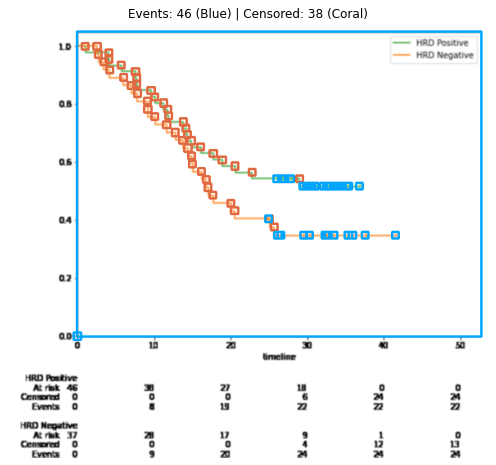

In [99]:
img_p = "/mnt/ONCOBOX/geneplus/workspace/chenly/dataset/images/train/double_real_000.png"
txt_p = "/mnt/ONCOBOX/geneplus/workspace/chenly/dataset/labels/train/double_real_000.txt"

def verify_labels_gentle_v2(img_path, txt_path):
    img = cv2.imread(img_path)
    if img is None:
        print("路径没找到，请检查路径是否正确")
        return
        
    h, w, _ = img.shape
    
    # --- 配色方案 (BGR格式) ---
    # 我们用宝蓝色系代表事件，橙黄系代表删失
    event_blue = (65, 105, 225)   # 宝蓝色  - 用于 Event
    censored_orange = (255, 165, 0)  # 橙黄色 - 用于 Censored
    
    event_cnt = 0
    censor_cnt = 0

    with open(txt_path, 'r') as f:
        for line in f:
            cls, x, y, bw, bh = map(float, line.split())
            
            # 统计
            if int(cls) == 0: event_cnt += 1
            else: censor_cnt += 1
            
            # 坐标转换
            x1 = int((x - bw/2) * w)
            y1 = int((y - bh/2) * h)
            x2 = int((x + bw/2) * w)
            y2 = int((y + bh/2) * h)
            
            # 使用 target_color 
            target_color = event_blue if int(cls) == 0 else  censored_orange
            
            # 让框变细，不遮挡曲线特征
            cv2.rectangle(img, (x1, y1), (x2, y2), target_color, 2)

    # 绘图显示
    plt.figure(figsize=(12, 8))
    # 注意：cv2 是 BGR，plt 需要转 RGB 才能显示我们设定的柔和色
    img_show = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    plt.imshow(img_show)
    plt.title(f"Events: {event_cnt} (Blue) | Censored: {censor_cnt} (Coral)", fontsize=12)
    plt.axis('off')
    plt.show()



# 确保调用的是带 _gentle_v2 的这个函数名
verify_labels_gentle_v2(img_p, txt_p)

## 自此，训练集初步完成。共计300对。
共生成cbioportal图片及对应yolo_lable.txt 250对，双臂HRD乳腺癌KM图及对应yolo_lable.txt 20对。TME三臂图对应yolo_lable.txt，30对。共计300对。后续可添加手动标注真实期刊KM图获得对应yolo_lable.txt，从而进一步完善模型训练集

### 验证测试集，KM生成JSON准确度

In [192]:
# ================= 配置区：在这里修改参数 =================
config = {
    "img_path": "/mnt/ONCOBOX/geneplus/workspace/chenly/dataset/images/train/double_real_000.png",
    "txt_path": "/mnt/ONCOBOX/geneplus/workspace/chenly/dataset/labels/train/double_real_000.txt",
    "save_folder": "/mnt/ONCOBOX/geneplus/workspace/chenly/KM_DATA/cbioprotal_download_km/TCGA卵巢癌HRD分组生存数据",
    "name_base": "double_real_000",
    
    # 物理坐标转换关键参数
    "t_max": 53,          # 横轴
    "y_offset": 0.015,    # 纵轴：向上平移微调量，如果还偏下就加大，偏上就减小
    "num_groups": 2       # 分组数量（双臂图设为2）
}
# =========================================================

In [193]:
import os

print(f"图片是否存在: {os.path.exists(config['img_path'])}")
print(f"标注是否存在: {os.path.exists(config['txt_path'])}")

# 自动创建不存在的输出文件夹
if not os.path.exists(config['save_folder']):
    os.makedirs(config['save_folder'])
    print(f"已新建输出文件夹: {config['save_folder']}")
else:
    print(f"输出文件夹已就绪: {config['save_folder']}")

图片是否存在: True
标注是否存在: True
输出文件夹已就绪: /mnt/ONCOBOX/geneplus/workspace/chenly/KM_DATA/cbioprotal_download_km/TCGA卵巢癌HRD分组生存数据


In [194]:
def extract_km_data(img_path, txt_path, cfg):
    img = cv2.imread(img_path)
    if img is None: return None, f"图片读取失败: {img_path}"
    h_img, w_img, _ = img.shape
    
    local_raw_points = []
    local_plot_bbox = None
    local_origin_pt = None

    if not os.path.exists(txt_path): return None, f"找不到标注文件: {txt_path}"

    # 1. 解析 YOLO TXT (归一化坐标)
    with open(txt_path, 'r', encoding='utf-8') as f:
        for line in f:
            parts = line.split()
            if not parts: continue
            cls, x, y, bw, bh = map(float, parts)
            if int(cls) == 2:    # Plot Area
                local_plot_bbox = {'y_top': y-bh/2, 'y_bottom': y+bh/2, 'x_left': x-bw/2, 'w': bw, 'h': bh}
            elif int(cls) == 3:  # Origin (Time=0, Survival=1.0)
                local_origin_pt = {'x': x, 'y': y}
            elif int(cls) in [0, 1]: # Data Points
                local_raw_points.append({'cls': int(cls), 'x': x, 'y': y})

    if local_plot_bbox is None: return None, "缺少 Plot Area 标注 (Class 2)"

    # 2. 颜色采样与聚类 (区分不同曲线)
    points_with_colors = []
    for pt in local_raw_points:
        px, py = int(pt['x'] * w_img), int(pt['y'] * h_img)
        # 边界检查
        px = np.clip(px, 2, w_img - 3)
        py = np.clip(py, 2, h_img - 3)
        roi = img[py-2:py+3, px-2:px+3]
        if roi.size == 0: continue
        pt['color'] = np.mean(roi, axis=(0, 1))
        points_with_colors.append(pt)

    if len(points_with_colors) < cfg["num_groups"]: return None, "有效数据点不足，无法聚类"

    colors = np.array([p['color'] for p in points_with_colors])
    _, labels, _ = cv2.kmeans(colors.astype(np.float32), cfg["num_groups"], None, 
                             (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 10, 1.0), 
                             10, cv2.KMEANS_RANDOM_CENTERS)

    # 3. 物理转换逻辑
    # YOLO y=0(顶), y=1(底)
    # Survival=1.0 在顶部 (y_100), Survival=0.0 在底部 (y_0)
    
    y_100 = local_origin_pt['y'] if local_origin_pt else local_plot_bbox['y_top']
    y_0 = local_plot_bbox['y_bottom']
    y_span = y_0 - y_100
    if y_span <= 0: y_span = local_plot_bbox['h'] if local_plot_bbox['h'] > 0 else 0.0001

    ref_x = local_origin_pt['x'] if local_origin_pt else local_plot_bbox['x_left']
    x_span = local_plot_bbox['w'] if local_plot_bbox['w'] > 0 else 0.0001

    temp_groups = {i: [] for i in range(cfg["num_groups"])}
    
    for i, pt in enumerate(points_with_colors):
        # --- Time 计算 ---
        # 点到原点的水平距离 / 总宽度 * 时间最大值
        time_val = ((pt['x'] - ref_x) / x_span) * cfg["t_max"]
        
        # --- Survival 计算 (反转逻辑) ---
        # 在YOLO系中，数值越大越靠下。
        # 掉落比例 = (点的y - 顶部y_100) / 总y高度
        drop_ratio = (pt['y'] - y_100) / y_span
        surv_val = 1.0 - drop_ratio + cfg.get("y_offset", 0)

        temp_groups[labels[i][0]].append({
            "type": "event" if pt['cls'] == 0 else "censored",
            "time": max(0, round(time_val, 2)),
            "survival": float(np.clip(round(surv_val, 4), 0, 1))
        })

    # 4. 自动判定 HRD 状态 (根据生存率曲线的高低)
    # 假设生存率均值高的是 Positive
    group_means = {i: np.mean([p['survival'] for p in temp_groups[i]]) for i in temp_groups}
    sorted_idx = sorted(group_means, key=group_means.get, reverse=True)

    named_groups = {
        "HRD_Positive": sorted(temp_groups[sorted_idx[0]], key=lambda x: x['time']),
        "HRD_Negative": sorted(temp_groups[sorted_idx[1]], key=lambda x: x['time'])
    }

    return named_groups, "Success"

def save_all_formats(data, status, folder, name_base):
    if data is None:
        print(f"❌ 错误: {status}")
        return
    if not os.path.exists(folder): os.makedirs(folder)
    
    # 1. 保存 JSON
    json_path = os.path.join(folder, f"{name_base}.json")
    with open(json_path, 'w', encoding='utf-8') as f:
        json.dump(data, f, indent=4, ensure_ascii=False)
    
    # 2. 保存 CSV
    rows = []
    for g_name, pts in data.items():
        for p in pts:
            rows.append({"group": g_name, "type": p['type'], "time": p['time'], "survival": p['survival']})
    
    csv_path = os.path.join(folder, f"{name_base}.csv")
    pd.DataFrame(rows).to_csv(csv_path, index=False)
    
    print(f"✅ 处理完成！")
    print(f"   JSON: {json_path}")
    print(f"   CSV:  {csv_path}")

# 执行
result, msg = extract_km_data(config["img_path"], config["txt_path"], config)
save_all_formats(result, msg, config["save_folder"], config["name_base"])

✅ 处理完成！
   JSON: /mnt/ONCOBOX/geneplus/workspace/chenly/KM_DATA/cbioprotal_download_km/TCGA卵巢癌HRD分组生存数据/double_real_000.json
   CSV:  /mnt/ONCOBOX/geneplus/workspace/chenly/KM_DATA/cbioprotal_download_km/TCGA卵巢癌HRD分组生存数据/double_real_000.csv


In [195]:
def compare_and_validate(original_csv_path, extracted_csv_path):
    # --- 1. 加载数据 ---
    # 修正：使用传入的变量名，确保路径正确加载
    df_orig = pd.read_csv(original_csv_path)
    df_pred = pd.read_csv(extracted_csv_path)
    
    t_col, e_col, g_col = 'PFS', 'PFS_EVENT', 'HRDStatus'

    plt.figure(figsize=(12, 7))
    kmf = KaplanMeierFitter()
    
    # 定义标准颜色对：蓝色(Positive/表现好), 橙色(Negative/表现差)
    color_map = {
        "Positive": "#1f77b4", # 蓝色
        "Negative": "#ff7f0e"  # 橙色
    }
    
    # --- 2. 绘制原始生存曲线 (Ground Truth) ---
    orig_groups = df_orig[g_col].unique()
    for g_name in orig_groups:
        # 根据组名包含关系选择颜色
        c = color_map["Positive"] if "Positive" in g_name else color_map["Negative"]
        
        mask = df_orig[g_col] == g_name
        kmf.fit(df_orig[mask][t_col], event_observed=df_orig[mask][e_col], label=f"Original: {g_name}")
        kmf.plot_survival_function(ax=plt.gca(), ci_show=False, color=c, linestyle='--', alpha=0.6)

    # --- 3. 绘制 API 提取出的点 (Predictions) ---
    pred_groups = df_pred['group'].unique()
    
    for pg_name in pred_groups:
        # 同样根据组名包含关系选择颜色，确保 Positive 对应蓝色点，Negative 对应橙色点
        c = color_map["Positive"] if "Positive" in pg_name else color_map["Negative"]
        
        p_mask = df_pred['group'] == pg_name
        p_data = df_pred[p_mask]
        
        events = p_data[p_data['type'] == 'event']
        censors = p_data[p_data['type'] == 'censored']
        
        # 绘制识别点
        plt.scatter(events['time'], events['survival'], color=c, 
                    s=40, label=f"Extracted Event ({pg_name})", zorder=5, edgecolors='white', linewidths=0.5)
        plt.scatter(censors['time'], censors['survival'], color=c, 
                    marker='+', s=100, label=f"Extracted Censor ({pg_name})", zorder=5)

    plt.title("稳定性验证：原始 TCGA 数据 vs YOLO 提取点 (HRD 分组对齐)", fontsize=14)
    plt.xlabel("Time (PFS) - Months", fontsize=12)
    plt.ylabel("Survival Probability", fontsize=12)
    plt.grid(True, linestyle=':', alpha=0.5)
    
    # 处理图例防止重复
    handles, labels = plt.gca().get_legend_handles_labels()
    by_label = dict(zip(labels, handles))
    plt.legend(by_label.values(), by_label.keys(), loc='upper right', fontsize=10)
    
    plt.show()

    # --- 4. 精度量化分析 ---
    print(f"--- 验证报告 ---")
    print(f"原始记录总数: {len(df_orig)}")
    print(f"API 提取总点数: {len(df_pred)}")
    
    # 计算丢失率
    if len(df_orig) != len(df_pred):
        diff = abs(len(df_orig) - len(df_pred))
        print(f" 注意：差异 {diff} 个点 (精度: {1 - diff/len(df_orig):.1%})")

In [196]:
# 调用
orig_p = "cbioprotal_download_km/TCGA卵巢癌HRD分组生存数据/TCGA卵巢癌HRD分组生存数据.csv"
ext_p = "chenly/KM_DATA/cbioprotal_download_km/TCGA卵巢癌HRD分组生存数据/double_real_000.json"

compare_and_validate(orig_p, ext_p)

ParserError: Error tokenizing data. C error: Expected 1 fields in line 4, saw 2
